In [6]:
import pandas as pd
import nltk
import string
from nltk.tokenize import word_tokenize

nltk.download('punkt')

queries = pd.read_csv('data/train_queries.csv', delimiter='\t')
queries['text'] = queries['text'].str.translate(str.maketrans('', '', string.punctuation))
docs = pd.read_json('data/docs.jsonl', lines=True)
qrels = pd.read_csv('data/train_qrels.csv', sep='\t')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christianjensen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from pandarallel import pandarallel
import re
from bs4 import BeautifulSoup
import nltk

# pre–compile your URL regex once
url_pattern = re.compile(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')

def clean_and_count(text):
    # strip HTML (use the faster lxml parser if you have it installed)
    text_no_html = BeautifulSoup(text, 'lxml').get_text()
    # remove URLs
    text_no_urls = url_pattern.sub('', text_no_html)
    # tokenize
    return len(nltk.word_tokenize(text_no_urls))

pandarallel.initialize(progress_bar=True)

docs['cleaned_body_word_count'] = docs['body'].parallel_apply(clean_and_count)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
print("Cleaned document length statistics:")
print(docs['cleaned_body_word_count'].describe())

Cleaned document length statistics:
count    200000.000000
mean       2130.232055
std        4037.443885
min           0.000000
25%         550.000000
50%        1035.000000
75%        2280.000000
max      413643.000000
Name: cleaned_body_word_count, dtype: float64


In [7]:
queries['query_word_count'] = queries['text'].apply(lambda x: len(word_tokenize(x)))

print("Query length statistics:")
print(queries['query_word_count'].describe())

Query length statistics:
count    4434.000000
mean        5.731845
std         2.372400
min         2.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        22.000000
Name: query_word_count, dtype: float64


In [8]:
docs['body_word_count'] = docs['body'].apply(lambda x: len(word_tokenize(x)))

print("Document length statistics:")
print(docs['body_word_count'].describe())

Document length statistics:
count    200000.000000
mean       2138.348505
std        4093.288622
min           0.000000
25%         551.000000
50%        1037.000000
75%        2285.000000
max      413646.000000
Name: body_word_count, dtype: float64


In [12]:
docs[(docs['body_word_count'] > 48) &(docs['body_word_count'] < 16481)]['body_word_count'].describe()

count    195952.000000
mean       1892.806320
std        2320.912385
min          49.000000
25%         559.000000
50%        1037.000000
75%        2246.000000
max       16478.000000
Name: body_word_count, dtype: float64

In [6]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
print(queries['query_word_count'].quantile(percentiles))
print()
print(docs['body_word_count'].quantile(percentiles))

from scipy.stats import skew
print("Skew of query lengths:", skew(queries['query_word_count']))

0.10     3.0
0.25     4.0
0.50     6.0
0.75     7.0
0.90     9.0
0.95    11.0
0.99    14.0
Name: query_word_count, dtype: float64

0.10      283.00
0.25      551.00
0.50     1037.00
0.75     2285.00
0.90     4713.00
0.95     7366.00
0.99    16481.12
Name: body_word_count, dtype: float64
Skew of query lengths: 1.3728262473577295


In [22]:
# Mark relevant docs
relevant_ids = qrels.loc[qrels['relevance'] > 0, 'docno']
docs = docs.copy()
docs['label'] = docs['docno'].isin(relevant_ids).astype(int)

# Pre-compute totals
total_docs     = len(docs)
total_relevant = docs['label'].sum()

# Compute quartile thresholds
q1  = docs['body_word_count'].quantile(0.01)
q99 = docs['body_word_count'].quantile(0.99)

def report(mask, description):
    subset          = docs[mask]
    count           = len(subset)
    pct_of_all      = count / total_docs * 100
    relevant_count  = subset['label'].sum()
    pct_of_relevant = relevant_count / total_relevant * 100

    print(f"{count} docs {description} "
          f"({pct_of_all:.2f}% of all docs)")
    print(f"{relevant_count} relevant docs {description} "
          f"({pct_of_relevant:.2f}% of relevant docs)\n")

# Below first quartile
report(
    docs['body_word_count'] < q1,
    f"with fewer than {q1:.0f} words"
)

# Above 99th percentile
report(
    docs['body_word_count'] > q99,
    f"with more than {q99:.0f} words"
)

1988 docs with fewer than 48 words (0.99% of all docs)
13 relevant docs with fewer than 48 words (0.29% of relevant docs)

2000 docs with more than 16481 words (1.00% of all docs)
32 relevant docs with more than 16481 words (0.73% of relevant docs)



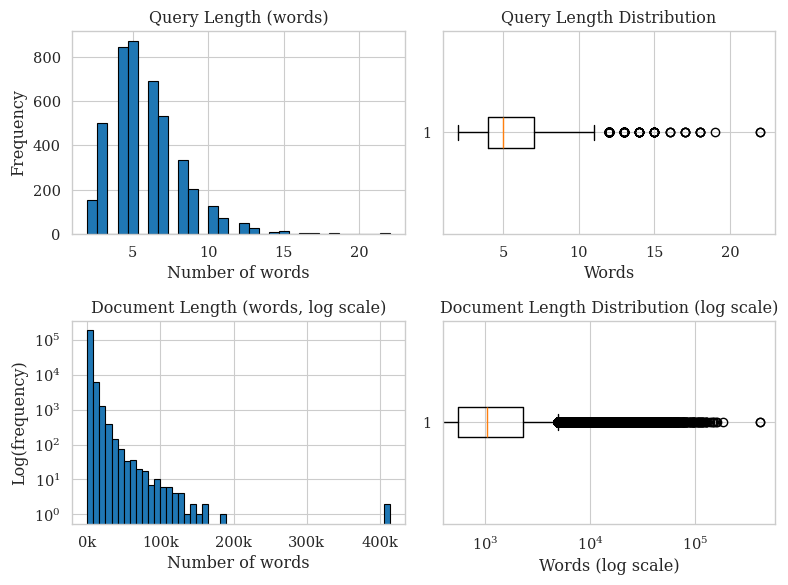

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set a clean, serif style and larger fonts:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)
plt.rc('font', family='serif')

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Query length histogram (words)
axes[0,0].hist(queries['query_word_count'], bins=30, edgecolor='black')
axes[0,0].set_title('Query Length (words)')
axes[0,0].set_xlabel('Number of words')
axes[0,0].set_ylabel('Frequency')

# Query boxplot
axes[0,1].boxplot(queries['query_word_count'], vert=False)
axes[0,1].set_title('Query Length Distribution')
axes[0,1].set_xlabel('Words')

# Document length histogram (log-y)
axes[1,0].hist(docs['body_word_count'], bins=50, edgecolor='black')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Document Length (words, log scale)')
axes[1,0].set_xlabel('Number of words')
axes[1,0].set_ylabel('Log(frequency)')
axes[1,0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

# Document boxplot
axes[1,1].boxplot(docs['body_word_count'], vert=False)
axes[1,1].set_title('Document Length Distribution (log scale)')
axes[1,1].set_xlabel('Words (log scale)')
axes[1,1].set_xscale('log')

plt.tight_layout()
plt.show()

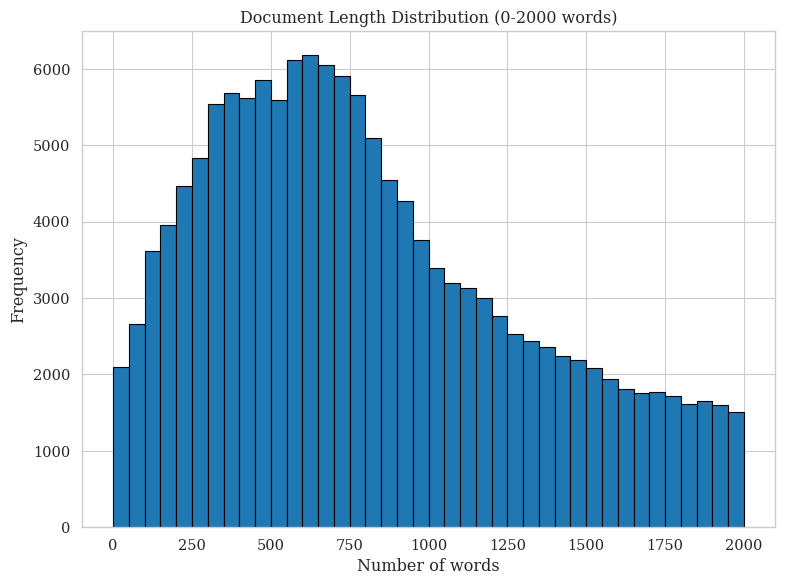

In [15]:
import matplotlib.pyplot as plt

# Plot histogram of docs up to 2 000 words
plt.figure(figsize=(8, 6))
plt.hist(
    docs['body_word_count'],
    bins=40,                # you can adjust bin count
    range=(0, 2000),        # limits x‐axis to 0–2000
    edgecolor='black'
)
plt.title('Document Length Distribution (0-2000 words)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [16]:
from collections import Counter
from nltk.tokenize import word_tokenize

# 1. Tokenize & normalize
tokens = [
    tok.lower()
    for text in queries['text'].astype(str)
    for tok in word_tokenize(text)
    if tok.isalpha()
]

# 2. Count & get top 20
freq = Counter(tokens)
top_20 = freq.most_common(20)

print("Top 20 words:")
for word, count in top_20:
    print(f"{word}: {count}")

Top 20 words:
what: 1726
is: 1698
the: 789
a: 639
of: 615
in: 569
how: 544
to: 347
for: 334
does: 323
are: 219
where: 212
do: 192
definition: 189
who: 178
was: 158
when: 156
and: 153
cost: 142
can: 135
